<a href="https://colab.research.google.com/github/kamijoseph/Fake-News/blob/main/fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import spacy
import textblob
import warnings
warnings.filterwarnings("ignore")


In [4]:
fake = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv")
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [6]:
fake["subject"].value_counts()

,count
subject,
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


<Axes: xlabel='subject', ylabel='count'>

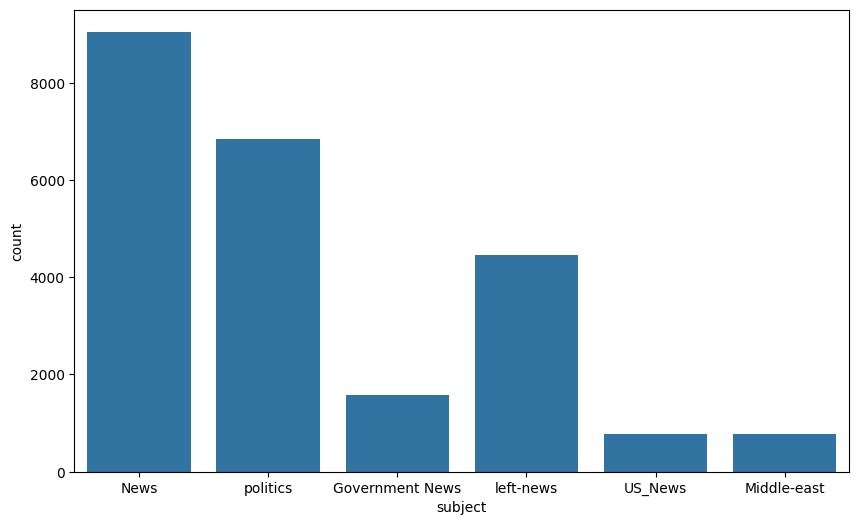

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x="subject", data=fake)

In [8]:
# visualizing text with word cloud
text = " ".join(fake["text"].tolist())

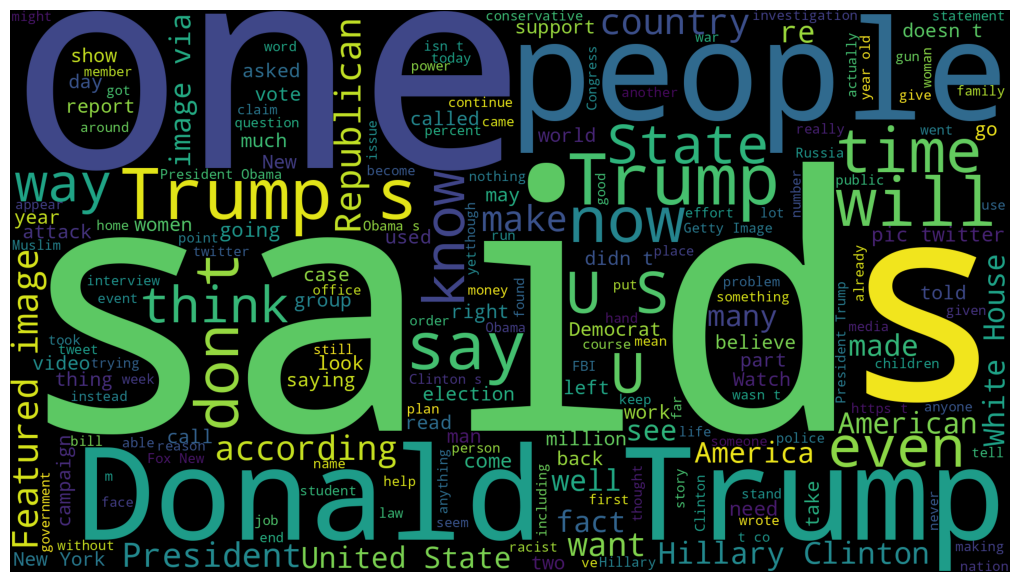

In [9]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [10]:
real = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [11]:
text_real = " ".join(real["text"].tolist())

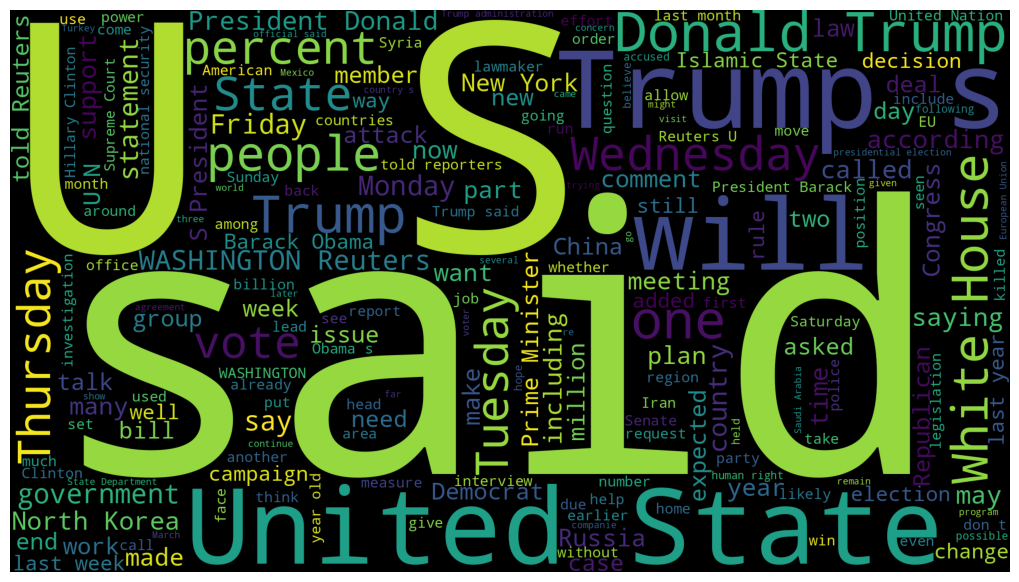

In [12]:
wordcloud = WordCloud(width=1920, height=1080).generate(text_real)
fig = plt.figure(figsize=(10, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Cleaning the data

In [13]:
real.sample(10)

,title,text,subject,date
8356,Bosnian Serbs make shoes for Melania Trump's W...,"BANJA LUKA, Bosnia (Reuters) - A Bosnian Serb ...",politicsNews,"August 29, 2016"
9447,Oklahoma governor vetoes bill to jail abortion...,(Reuters) - Oklahoma’s Republican Governor Mar...,politicsNews,"May 20, 2016"
6151,Senate confirms retired generals as first two ...,WASHINGTON (Reuters) - The U.S. Senate confirm...,politicsNews,"January 20, 2017"
14994,Southeast Asia summit draft statement skips ov...,MANILA (Reuters) - A draft of the statement to...,worldnews,"November 13, 2017"
1387,Republicans move on tax reform; Fed officials ...,WASHINGTON (Reuters) - Congressional Republica...,politicsNews,"October 5, 2017"
9154,House panel to consider measure censuring IRS ...,WASHINGTON (Reuters) - A Republican-controlled...,politicsNews,"June 13, 2016"
12891,Syrian govt delegation to return to Geneva on ...,BEIRUT (Reuters) - Syrian President Bashar al-...,worldnews,"December 7, 2017"
16994,Putin says Trump hampered from delivering elec...,"SOCHI, Russia (Reuters) - Russian President Vl...",worldnews,"October 19, 2017"
19131,Swedish court sentences Syrian asylum seeker t...,STOCKHOLM (Reuters) - A Swedish court on Monda...,worldnews,"September 25, 2017"
3300,"Trump attorney disputes Comey testimony, slams...",WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,"June 8, 2017"


In [14]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split("-", maxsplit=1)
    record[1]
    assert(len(record[0]) < 120)
  except:
    unknown_publishers.append(index)


In [15]:
len(unknown_publishers)

222

In [16]:
real.iloc[unknown_publishers].text

,text
7,The following statements were posted to the ve...
8,The following statements were posted to the ve...
12,The following statements were posted to the ve...
13,The following statements were posted to the ve...
14,"(In Dec. 25 story, in second paragraph, corre..."
...,...
20135,(Story corrects to million from billion in pa...
20500,"(This Sept 8 story corrects headline, clarifi..."
20667,"(Story refiles to add dropped word not , in ..."
21246,(Story corrects third paragraph to show Mosul...


In [17]:
real.iloc[8970]

,8970
title,Graphic: Supreme Court roundup
text,
subject,politicsNews
date,"June 16, 2016"


In [18]:
real = real.drop(8970, axis=0)

In [19]:
publisher = []
tmp_text = []
for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append("Unknown")
  else:
    record = row.split("-", maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [20]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [21]:
real["publisher"] = publisher
real["text"] = tmp_text

In [22]:
real.sample(10)

,title,text,subject,date,publisher
7172,"Factbox: The nasty things Trump, Romney have s...",Even for a 2016 election campaign marked by rh...,politicsNews,"November 18, 2016",(Reuters)
2766,House Speaker Ryan urges Trump son to testify ...,U.S. House of Representatives Speaker Paul Rya...,politicsNews,"July 13, 2017",WASHINGTON (Reuters)
8386,Democrat Clinton vows to support Colombia-FARC...,Democratic presidential candidate Hillary Clin...,politicsNews,"August 25, 2016",WASHINGTON (Reuters)
13486,At least 800 civilians killed by coalition str...,At least 800 civilians have been killed in str...,worldnews,"November 30, 2017",BAGHDAD (Reuters)
16119,Bahrain calls for freezing Qatar out of GCC,Bahrain will not attend December s summit of t...,worldnews,"October 29, 2017",DUBAI (Reuters)
5247,Republicans will fail in Obamacare repeal bid:...,The top Democrat in the U.S. Senate predicted ...,politicsNews,"February 27, 2017",WASHINGTON (Reuters)
8862,U.S. attorney general to testify before House ...,U.S. Attorney General Loretta Lynch will testi...,politicsNews,"July 6, 2016",(Reuters)
2823,House intel committee wants Trump Jr. to appea...,The U.S. House Intelligence Committee wants Do...,politicsNews,"July 11, 2017",WASHINGTON (Reuters)
21260,Vietnam's Facebook dissidents test the limits ...,"This isn t like China, says Vietnamese activi...",worldnews,"August 29, 2017",HANOI (Reuters)
4160,"U.S., Iran trade barbs over landmark 2015 nucl...",Iran and the United States traded barbs over t...,politicsNews,"April 20, 2017",BEIRUT/WASHINGTON (Reuters)


In [23]:
real.shape

(21416, 5)

In [24]:
fake.shape

(23481, 4)

In [25]:
empty_fake_index = [index for index, text in enumerate(fake.text.to_list()) if str(text).strip()==""]
len(empty_fake_index)

630

In [26]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [27]:
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [28]:
real.sample(10)

,title,text,subject,date,publisher
14528,Lebanon's Middle East Airlines lifts electroni...,Lebanon's Middle East Airlines lifts electroni...,worldnews,"November 17, 2017",BEIRUT (Reuters)
3101,"China invites Ivanka Trump, Jared Kushner to v...","China invites Ivanka Trump, Jared Kushner to v...",politicsNews,"June 20, 2017",WASHINGTON/BEIJING (Reuters)
6279,Boeing CEO sees 'near term' plane deal after T...,Boeing CEO sees 'near term' plane deal after T...,politicsNews,"January 17, 2017",(Reuters)
18396,"Trying to reset agenda, UK's May sets out to t...","Trying to reset agenda, UK's May sets out to t...",worldnews,"October 2, 2017","MANCHESTER, England (Reuters)"
4778,U.S. sticks to global transparency initiative ...,U.S. sticks to global transparency initiative ...,politicsNews,"March 22, 2017",WASHINGTON/OSLO (Reuters)
10649,Clinton opposes recommendation to drop limits ...,Clinton opposes recommendation to drop limits ...,politicsNews,"February 26, 2016","COLUMBIA, S.C. (Reuters)"
161,Do not expect postcard-sized tax return from R...,Do not expect postcard-sized tax return from R...,politicsNews,"December 14, 2017",WASHINGTON (Reuters)
14233,"Iran's Rouhani urges France to remain ""realist...","Iran's Rouhani urges France to remain ""realist...",worldnews,"November 21, 2017",BEIRUT/PARIS (Reuters)
18268,Ukraine expels another Russian journalist over...,Ukraine expels another Russian journalist over...,worldnews,"October 5, 2017",KIEV (Reuters)
8481,Factbox: Why the Zika virus is causing alarm,Factbox: Why the Zika virus is causing alarm G...,politicsNews,"August 11, 2016",Unknown


In [29]:
real["text"] = real["text"].apply(lambda x: str(x).lower())
fake["text"] = fake["text"].apply(lambda x: str(x).lower())

In [30]:
real.sample(10)

,title,text,subject,date,publisher
14623,Libyans swap jewelry for medical treatment as ...,libyans swap jewelry for medical treatment as ...,worldnews,"November 16, 2017",TRIPOLI (Reuters)
6803,Oil drilling advocate to be Trump pick for Int...,oil drilling advocate to be trump pick for int...,politicsNews,"December 9, 2016",WASHINGTON (Reuters)
15592,Lebanon monetary situation stable after PM qui...,lebanon monetary situation stable after pm qui...,worldnews,"November 6, 2017",BEIRUT (Reuters)
15097,"EU wants Brexit money this month, Davis seeks ...","eu wants brexit money this month, davis seeks ...",worldnews,"November 10, 2017",BRUSSELS (Reuters)
4196,"U.S. consumers could suffer from Dodd-Frank, C...","u.s. consumers could suffer from dodd-frank, c...",politicsNews,"April 19, 2017",WASHINGTON (Reuters)
20120,German court rules public should have free acc...,german court rules public should have free acc...,worldnews,"September 14, 2017",FRANKFURT (Reuters)
2078,Top U.S. general in Afghanistan says new strat...,top u.s. general in afghanistan says new strat...,politicsNews,"August 22, 2017",WASHINGTON (Reuters)
6090,Senate panel clears Tillerson's path to be sec...,senate panel clears tillerson's path to be sec...,politicsNews,"January 23, 2017",WASHINGTON (Reuters)
12142,Wounded North Korean defector transferred to S...,wounded north korean defector transferred to s...,worldnews,"December 16, 2017",SEOUL (Reuters)
10114,Nuclear terrorism fears loom over Obama's fina...,nuclear terrorism fears loom over obama's fina...,politicsNews,"March 30, 2016",WASHINGTON (Reuters)


In [31]:
fake.sample(10)

,title,text,subject,date
18881,PROFESSOR Gives Instruction For What’s Accepta...,professor gives instruction for what’s accepta...,left-news,"Apr 1, 2017"
1103,Watch Malcolm Nance WIPE THE FLOOR With Breit...,watch malcolm nance wipe the floor with breit...,News,"June 17, 2017"
1253,WATCH: Sean Spicer Fails SPECTACULARLY When A...,watch: sean spicer fails spectacularly when a...,News,"June 6, 2017"
19798,BUSTED! THE MOST DAMAGING Clinton Foundation E...,busted! the most damaging clinton foundation e...,left-news,"Oct 15, 2016"
1850,Images Of Trump Golfing In Florida Leak Despi...,images of trump golfing in florida leak despi...,News,"April 8, 2017"
536,Even Robert E. Lee Didn’t Want Confederate Mo...,even robert e. lee didn’t want confederate mo...,News,"August 18, 2017"
22133,ENGDAHL: ‘Trump is a Puppet of the Deep State’,engdahl: ‘trump is a puppet of the deep state’...,US_News,"April 7, 2017"
22958,‘A DELIRIUM IS SPREADING’ – The Left’s Great R...,‘a delirium is spreading’ – the left’s great r...,Middle-east,"March 11, 2017"
13270,JUDGE JEANINE Tells Us What The Smoking Gun Is...,judge jeanine tells us what the smoking gun is...,politics,"Aug 12, 2016"
9568,LOL! ANTI-TRUMP ACTORS George Clooney and Matt...,lol! anti-trump actors george clooney and matt...,politics,"Oct 29, 2017"


In [32]:
real.tail(10)

,title,text,subject,date,publisher
21407,"Mata Pires, owner of embattled Brazil builder ...","mata pires, owner of embattled brazil builder ...",worldnews,"August 22, 2017",SAO PAULO (Reuters)
21408,"U.S., North Korea clash at U.N. forum over nuc...","u.s., north korea clash at u.n. forum over nuc...",worldnews,"August 22, 2017",GENEVA (Reuters)
21409,"U.S., North Korea clash at U.N. arms forum on ...","u.s., north korea clash at u.n. arms forum on ...",worldnews,"August 22, 2017",GENEVA (Reuters)
21410,Headless torso could belong to submarine journ...,headless torso could belong to submarine journ...,worldnews,"August 22, 2017",COPENHAGEN (Reuters)
21411,North Korea shipments to Syria chemical arms a...,north korea shipments to syria chemical arms a...,worldnews,"August 21, 2017",UNITED NATIONS (Reuters)
21412,'Fully committed' NATO backs new U.S. approach...,'fully committed' nato backs new u.s. approach...,worldnews,"August 22, 2017",BRUSSELS (Reuters)
21413,LexisNexis withdrew two products from Chinese ...,lexisnexis withdrew two products from chinese ...,worldnews,"August 22, 2017",LONDON (Reuters)
21414,Minsk cultural hub becomes haven from authorities,minsk cultural hub becomes haven from authorit...,worldnews,"August 22, 2017",MINSK (Reuters)
21415,Vatican upbeat on possibility of Pope Francis ...,vatican upbeat on possibility of pope francis ...,worldnews,"August 22, 2017",MOSCOW (Reuters)
21416,Indonesia to buy $1.14 billion worth of Russia...,indonesia to buy $1.14 billion worth of russia...,worldnews,"August 22, 2017",JAKARTA (Reuters)


In [33]:
fake.sample(10)

,title,text,subject,date
7110,These Panties Let You Protest Anti-Choice Rep...,these panties let you protest anti-choice rep...,News,"April 3, 2016"
2640,Trump Attacks President Obama For Trying To M...,trump attacks president obama for trying to m...,News,"February 7, 2017"
3527,Tina Fey SKEWERS Trump For Being A ‘Chump’ Wh...,tina fey skewers trump for being a ‘chump’ wh...,News,"December 7, 2016"
3456,"WATCH: Trump Defends Russia, So John McCain H...","watch: trump defends russia, so john mccain h...",News,"December 11, 2016"
5844,TX Teacher Infuriates Mother With Note Implyi...,tx teacher infuriates mother with note implyi...,News,"June 17, 2016"
3810,"Obama Takes Pity On Trump, Plans To Hold His ...","obama takes pity on trump, plans to hold his ...",News,"November 14, 2016"
18894,5-YEAR OLD SUSPENDED FROM SCHOOL For Playing W...,5-year old suspended from school for playing w...,left-news,"Mar 29, 2017"
4095,The Daily Caller Edits Woman’s Tragic Pregnan...,the daily caller edits woman’s tragic pregnan...,News,"October 21, 2016"
13048,IF HILLARY IS ELECTED And Becomes Too Sick To ...,if hillary is elected and becomes too sick to ...,politics,"Sep 10, 2016"
15583,THE STATE THAT GETS MORE REFUGEES THAN ANY OTH...,the state that gets more refugees than any oth...,politics,"Jun 11, 2015"


In [34]:
# labels
real["class"] = 1
fake["class"] = 0
print(real.columns, fake.columns)

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object') Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')


In [35]:
real = real[
    ["text", "class"]
]
fake = fake[
    ["text", "class"]
]
print(real.shape, fake.shape)

(21416, 2) (23481, 2)


In [36]:
data = pd.concat([real, fake], ignore_index=True)
data.sample(10)

,text,class
7192,trump team will receive first pentagon briefin...,1
19469,saudi king to visit russia: ria cites kremlin ...,1
39425,n korea just revealed plans to unleash an unim...,0
19011,danish minister republishes controversial prop...,1
17698,new zealand held in suspense as kingmaker weig...,1
3812,u.s. senate confirms trump trade representativ...,1
41851,breaking: gay bernie sanders supporter with lo...,0
25195,white tv anchor proves systemic media racism ...,0
28733,republican outrageously slanders hillary by c...,0
22728,new poll is devastating news for trump – it’s...,0


In [37]:
data.shape

(44897, 2)

In [38]:
data["class"].value_counts()

,count
class,
0,23481
1,21416


In [39]:
data.isnull().sum()

,0
text,0
class,0


In [40]:
data["text"].head(10)

,text
0,"as u.s. budget fight looms, republicans flip t..."
1,u.s. military to accept transgender recruits o...
2,senior u.s. republican senator: 'let mr. muell...
3,fbi russia probe helped by australian diplomat...
4,trump wants postal service to charge 'much mor...
5,"white house, congress prepare for talks on spe..."
6,"trump says russia probe will be fair, but time..."
7,factbox: trump on twitter (dec 29) - approval ...
8,trump on twitter (dec 28) - global warming the...
9,alabama official to certify senator-elect jone...


In [41]:
!pip install beautifulsoup4
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

In [42]:
!pip install googletrans==4.0.0-rc1

In [43]:
import preprocess_kgptalkie as ps

In [44]:
data["text"].apply(lambda x: ps.remove_special_chars(x))
data["text"].sample(10)

,text
40865,politico writer suggests trump is having sex w...
17779,"hungary demands faster eu, nato integration of..."
11938,"brace for a uk election next year, opposition ..."
1673,trump choice for russia ambassador: 'no questi...
39919,austria’s not playing games: bans face-conceal...
39074,awesome! conservative artist crashes anti-trum...
33158,patriots owner on trump: “in the toughest time...
20631,lebanese army to deploy along entire eastern b...
2235,senators urge trump to avoid blockade of venez...
44142,thanksgiving day fake news turkey shoot: boile...


In [45]:
data["text"].head(10)

,text
0,"as u.s. budget fight looms, republicans flip t..."
1,u.s. military to accept transgender recruits o...
2,senior u.s. republican senator: 'let mr. muell...
3,fbi russia probe helped by australian diplomat...
4,trump wants postal service to charge 'much mor...
5,"white house, congress prepare for talks on spe..."
6,"trump says russia probe will be fair, but time..."
7,factbox: trump on twitter (dec 29) - approval ...
8,trump on twitter (dec 28) - global warming the...
9,alabama official to certify senator-elect jone...


In [46]:
!pip install gensim

Vectorization using word2vec

In [47]:
import multiprocessing
from gensim.models import Word2Vec

In [48]:
data.head()

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


In [49]:
y = data["class"].values
y

array([1, 1, 1, ..., 0, 0, 0])

In [50]:
X = [d.split() for d in data["text"].tolist()]

In [69]:
DIM = 100

In [51]:
w2v_model = Word2Vec(
    sentences=X,
    vector_size=100,
    window=10,
    min_count=2,
    workers=multiprocessing.cpu_count()
)

In [52]:
len(w2v_model.wv.key_to_index)

203795

In [ ]:
list(w2v_model.wv.index_to_key)

In [54]:
vector = w2v_model.wv.get_vector("love")
vector

array([ 1.6236840e-01,  1.3005954e+00, -2.8478816e+00,  4.2143461e-01,
       -3.7299496e-01,  1.1739286e+00, -2.4281092e+00, -1.0554858e+00,
       -6.0691853e+00, -6.4828911e+00, -1.4342729e+00,  1.8715453e+00,
        1.5526779e+00, -1.0817311e-01,  9.3289655e-01, -1.8268577e+00,
        9.7212112e-01, -2.9866841e+00,  3.5767663e+00,  4.9777058e-01,
        2.5806854e+00,  1.2812103e+00,  9.2325127e-01, -3.4196630e-01,
       -1.4833926e+00,  1.3297855e+00, -3.5675750e+00,  8.5163128e-01,
       -1.5097139e+00,  4.1700449e+00,  1.3735929e+00,  1.1276261e+00,
       -2.4589684e+00, -1.2594060e+00, -3.7453189e+00,  1.2589386e+00,
       -3.7792466e+00, -4.5320582e+00,  6.3087726e-01, -1.0267079e+00,
        2.8446345e+00,  7.5788915e-02,  2.9162960e+00,  2.5004299e+00,
        2.7804883e+00,  3.1469455e+00, -1.1815503e+00, -3.7046468e+00,
        5.6164485e-01, -8.0037934e-01, -9.7930467e-01,  3.7426708e+00,
       -1.8802513e+00,  1.0192995e+00, -6.2942088e-01,  3.9535842e+00,
      

In [ ]:
X

In [56]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X)

In [57]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

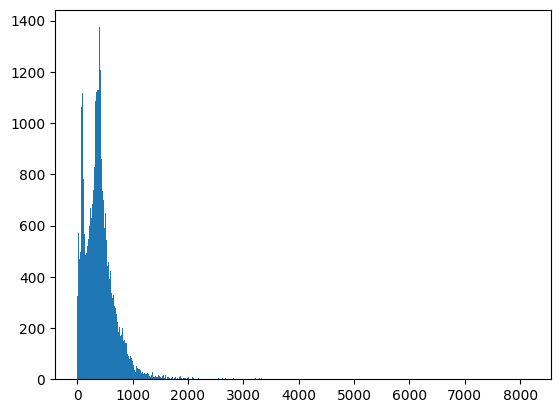

In [59]:
plt.hist(
    [len(x) for x in X],
    bins = 700
)
plt.show()

In [60]:
nos = np.array([len(x) for x in X])
len(nos[nos > 1000])

1603

In [61]:
maxlen = 1000
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=maxlen)
len(X[101])

1000

In [72]:
vocab = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

In [76]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))
    for word, i in vocab.items():
        if word in model.wv.key_to_index:
            weight_matrix[i] = model.wv[word]

    return weight_matrix


In [77]:
# embeddingd vectors
embedding_vectors = get_weight_matrix(w2v_model)

In [79]:
embedding_vectors.shape

(375374, 100)